<a href="https://colab.research.google.com/github/present42/PyTorchPractice/blob/main/Triton_Official_Tutorial_(1)_Vector_Addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link



In [5]:
import torch

import triton
import triton.language as tl

@triton.jit
def add_kernel(x_ptr,
               y_ptr,
               output_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr,
               ):
  pid = tl.program_id(axis=0) # there are multiple programs processing different data

  block_start = pid * BLOCK_SIZE
  offsets = block_start + tl.arange(0, BLOCK_SIZE) # offsets = a list of pointers

  mask = offsets < n_elements

  x = tl.load(x_ptr + offsets, mask=mask)
  y = tl.load(y_ptr + offsets, mask=mask)

  output = x + y

  tl.store(output_ptr + offsets, output, mask=mask)

In [6]:
def add(x: torch.Tensor, y: torch.Tensor):
  output = torch.empty_like(x)

  assert x.is_cuda and y.is_cuda and output.is_cuda

  n_elements = output.numel()

  # SPMD = single program multiple memory
  grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

  add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)

  return output

In [7]:
torch.manual_seed(0)

size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}")

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [14]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log = True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={},
  ))
def benchmark(size, provider):
  x = torch.rand(size, device='cuda', dtype=torch.float32)
  y = torch.rand(size, device='cuda', dtype=torch.float32)
  quantiles = [0.5, 0.2, 0.8]
  if provider == 'torch':
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
  if provider == 'triton':
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
  gbps = lambda ms: 12 * size / ms * 1e-6
  return gbps(ms), gbps(min_ms), gbps(min_ms)

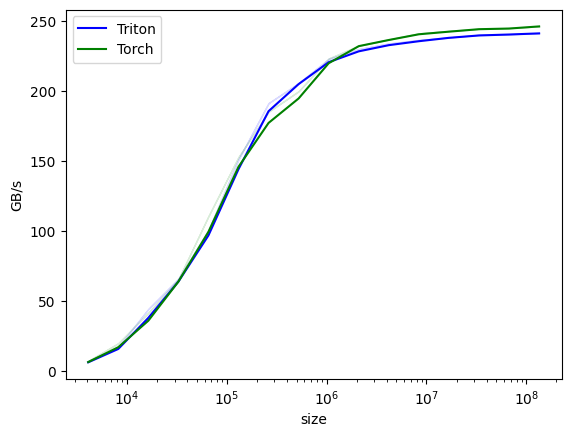

vector-add-performance:
           size      Triton       Torch
0        4096.0    6.481013    6.678261
1        8192.0   15.999999   17.258427
2       16384.0   38.161490   36.141177
3       32768.0   63.999998   63.999998
4       65536.0   96.946742   99.497980
5      131072.0  144.140760  145.851630
6      262144.0  185.479239  177.124332
7      524288.0  204.800005  194.565065
8     1048576.0  220.412561  219.673742
9     2097152.0  228.149700  231.849058
10    4194304.0  232.551780  236.236710
11    8388608.0  235.370603  240.315363
12   16777216.0  237.772341  242.174687
13   33554432.0  239.473806  243.930513
14   67108864.0  240.143362  244.398396
15  134217728.0  240.946371  245.913703


In [15]:
benchmark.run(print_data=True, show_plots=True)